In [110]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from mapie.classification import MapieClassifier
from mapie.metrics import (classification_coverage_score,
                           classification_mean_width_score)
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split

# Suppress the specific warning
warnings.filterwarnings("ignore", message="X does not have valid feature names")
warnings.filterwarnings("ignore", message="'force_all_finite' was renamed to 'ensure_all_finite'")


# Load Covertype dataset (7 classes)
covertype = fetch_openml(name='covertype', version=4, as_frame=False)
X, y = covertype.data, covertype.target

# Convert the data to pandas DataFrame to handle NaN values
X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y)

# Drop rows with NaN values in both X and y
X_df_cleaned = X_df.dropna()
y_df_cleaned = y_df.loc[X_df_cleaned.index]  # Ensure y corresponds to the rows that remain

# Convert the cleaned DataFrames back to numpy arrays
X_cleaned = X_df_cleaned.values
y_cleaned = y_df_cleaned.values

# Subset for faster execution (optional)
X_cleaned, y_cleaned = X_cleaned[:500000], y_cleaned[:500000]  # Use first 500K samples

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.2, random_state=42)


y_train = y_train.astype(int)
y_test = y_test.astype(int)

#These modifications are done so that the MAPIE functions for mean prediction size and coverage calculations can be done effectively
y_train = y_train -1
y_test = y_test -1

y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)


In [111]:
alpha = np.linspace(0.01, 0.5, 50)
expectation_iter = 500
sample_size = 3000

In [112]:
def repeat_sampling(num_epochs, sample_size):
    def decorator(func):
        def wrapper(X_full_test, y_full_test, *args, **kwargs):
            all_coverages = []
            all_widths = []

            for epoch in range(num_epochs):
                np.random.seed(epoch)

                # Stratified split based on labels
                X_test_new, X_calib, y_test_new, y_calib = train_test_split(
                    X_full_test, y_full_test,
                    test_size=sample_size,
                    stratify=y_full_test,
                    random_state=epoch
                )

                coverage, width = func(
                    X_calib, y_calib,
                    X_test_new, y_test_new,
                    *args, **kwargs
                )
                all_coverages.append(coverage)
                all_widths.append(width)

            mean_coverage = np.mean(all_coverages, axis=0)
            mean_width = np.mean(all_widths, axis=0)
            return mean_coverage, mean_width
        return wrapper
    return decorator

In [113]:
#train the models
#Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train, y_train)

#LightGBM
lgbm_classifier = lgb.LGBMClassifier(
	objective='multiclass',
	boosting_type='gbdt',
	n_estimators=100,
	learning_rate=0.15,
	max_depth=10,
	device='gpu',
	gpu_use_dp=False,         # Use single precision (faster)
	num_class=len(set(y_train)),  # Set number of classes
	verbosity=-1
)

# Train the model
lgbm_classifier.fit(X_train, y_train)

LGBMClassifier(device='gpu', gpu_use_dp=False, learning_rate=0.15, max_depth=10,
               num_class=7, objective='multiclass', verbosity=-1)

In [114]:
@repeat_sampling(num_epochs=expectation_iter, sample_size=sample_size)
def run_gnb_with_mapie(X_calib, y_calib,X_test, y_test, alpha):

	mapie_gnb = MapieClassifier(estimator=gnb, method="lac", cv="prefit") 
	mapie_gnb.fit(X_calib, y_calib)

	act_pred_gnb, pred_set_gnb = mapie_gnb.predict(X_test, alpha=alpha)

	coverages_score_gnb = [classification_coverage_score(y_test, pred_set_gnb[:, :, i]) for i, _ in enumerate(alpha)]
	widths_score_gnb = [classification_mean_width_score(pred_set_gnb[:, :, i]) for i, _ in enumerate(alpha)]

	return widths_score_gnb, coverages_score_gnb


In [115]:
@repeat_sampling(num_epochs=expectation_iter, sample_size=sample_size)
def run_lgbm_with_mapie(X_calib, y_calib, X_test, y_test, alpha):


    # Apply MAPIE for conformal prediction (LAC method)
    mapie_lgbm = MapieClassifier(estimator=lgbm_classifier, method="lac", cv="prefit")
    mapie_lgbm.fit(X_calib, y_calib)

    act_pred_lgbm, pred_set_lgbm = mapie_lgbm.predict(X_test, alpha=alpha)

    # Compute coverage and width metrics
    coverages_score_lgbm = [classification_coverage_score(y_test, pred_set_lgbm[:, :, i]) for i, _ in enumerate(alpha)]
    widths_score_lgbm = [classification_mean_width_score(pred_set_lgbm[:, :, i]) for i, _ in enumerate(alpha)]

    return widths_score_lgbm, coverages_score_lgbm

In [116]:
widths_score_lgm, coverages_score_lgm = run_lgbm_with_mapie( X_test, y_test, alpha)
widths_score_gnb, coverages_score_gnb  = run_gnb_with_mapie( X_test, y_test, alpha)

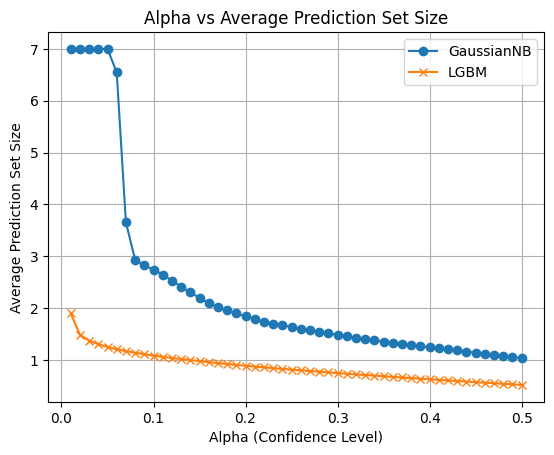

In [117]:
plt.plot(alpha, widths_score_gnb, label='GaussianNB', marker='o')
plt.plot(alpha, widths_score_lgm, label='LGBM', marker='x')

# Adding labels and title
plt.xlabel('Alpha (Confidence Level)')
plt.ylabel('Average Prediction Set Size')
plt.title('Alpha vs Average Prediction Set Size')

# Display legend
plt.legend()

# Adding grid
plt.grid(True)

# Show the plot
plt.show()

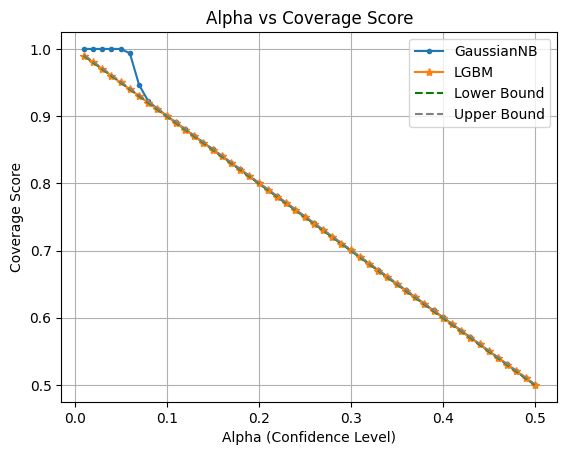

In [118]:
lower_coverage = [1-x for x in alpha]
upper_coverage = [1-x + 0.001 for x in alpha]
plt.plot(alpha, coverages_score_gnb, label='GaussianNB', marker='.')
plt.plot(alpha, coverages_score_lgm, label='LGBM', marker='*')
plt.plot(alpha, lower_coverage, label='Lower Bound', linestyle='--', color='green')
plt.plot(alpha, upper_coverage, label='Upper Bound', linestyle='--', color='gray')
# Adding labels and title
plt.xlabel('Alpha (Confidence Level)')
plt.ylabel('Coverage Score')
plt.title('Alpha vs Coverage Score')
# Display legend
plt.legend()
# Adding grid
plt.grid(True)
# Show the plot
plt.show()


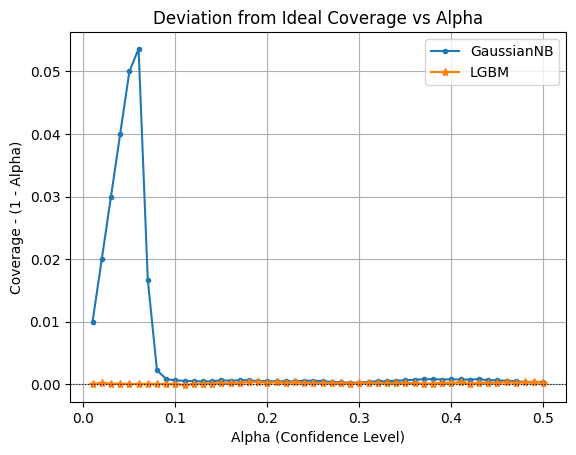

In [119]:
import matplotlib.pyplot as plt

# Compute the ideal coverage (1 - alpha)
ideal_coverage = [1 - x for x in alpha]

# Difference from ideal coverage
diff_gnb = [c - ic for c, ic in zip(coverages_score_gnb, ideal_coverage)]
diff_lgm = [c - ic for c, ic in zip(coverages_score_lgm, ideal_coverage)]

# Plotting deviations from ideal coverage
plt.plot(alpha, diff_gnb, label='GaussianNB', marker='.')
plt.plot(alpha, diff_lgm, label='LGBM', marker='*')

# Add a horizontal y=0 line for reference
plt.axhline(0, color='black', linewidth=0.8, linestyle=':')

# Labels and title
plt.xlabel('Alpha (Confidence Level)')
plt.ylabel('Coverage - (1 - Alpha)')
plt.title('Deviation from Ideal Coverage vs Alpha')

# Legend and grid
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'mapie_gnb' is not defined

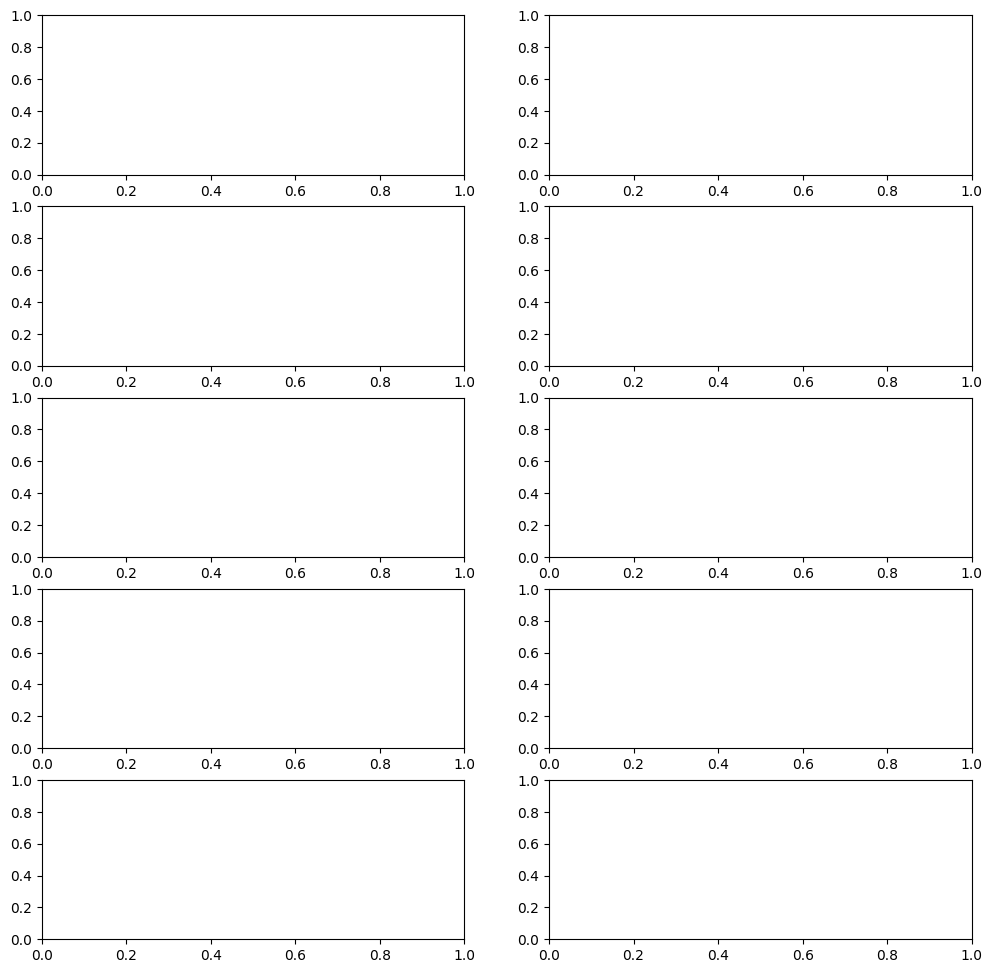

In [120]:
import numpy as np
import matplotlib.pyplot as plt

# Testing for various values of alpha
alpha_values = [0.005, 0.01, 0.03, 0.05, 0.1]

num_samples = 500

fig, axes = plt.subplots(len(alpha_values), 2, figsize=(12, 12))

for i, alpha_val in enumerate(alpha_values):
    # Predictions
    _, pred_set_gnb = mapie_gnb.predict(X_test, alpha=[alpha_val])
    _, pred_set_lgm = mapie_lgm.predict(X_test, alpha=[alpha_val])
    
    # Randomly sampling
    random_indices = np.random.choice(len(X_test), num_samples, replace=False)

    # Compute set sizes
    set_sizes_gnb = [np.sum(pred_set_gnb[idx, :, 0]) for idx in random_indices]
    set_sizes_lgm = [np.sum(pred_set_lgm[idx, :, 0]) for idx in random_indices]

    # Plot GaussianNB histogram
    axes[i, 0].hist(set_sizes_gnb, bins=range(1, 8), alpha=0.6, color='blue', edgecolor='black')
    axes[i, 0].set_xlabel("Prediction Set Size")
    axes[i, 0].set_ylabel("Frequency")
    axes[i, 0].set_title(f"GaussianNB - α={alpha_val}")

    # Plot LightGBM histogram
    axes[i, 1].hist(set_sizes_lgm, bins=range(1, 8), alpha=0.6, color='green', edgecolor='black')
    axes[i, 1].set_xlabel("Prediction Set Size")
    axes[i, 1].set_ylabel("Frequency")
    axes[i, 1].set_title(f"LightGBM - α={alpha_val}")

plt.tight_layout()
plt.show()
